In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

Need to interpolate eocene data onto NEMO grid 720x360 or interpolate both on a regular grid 

In [2]:
path_modern = "/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/nemo"
path_eocene = "/perm/itas/data/deepMIP/Herold_etal_2014"

In [3]:
topo_eocene = xr.open_dataset(f"{path_eocene}/herold_etal_eocene_topo_1x1.nc")
domain_modern = xr.open_dataset(f"{path_modern}/domain/ORCA1/domain_cfg.nc")

In [4]:
iwm_modern = xr.open_dataset(f"{path_modern}/initial/zdfiwm_forcing_r720x360.nc")
iwm_eocene = xr.open_dataset(f"{path_eocene}/Green_Huber_eocene_tidal_dissipation_1x1.nc")

In [5]:
topo_eocene['bathymetry'] = -topo_eocene['topo'].where(topo_eocene['topo'] < 0)

In [6]:
iwm_modern

<xarray.Dataset> Size: 15MB
Dimensions:     (latitude: 360, longitude: 720)
Coordinates:
  * latitude    (latitude) float64 3kB -90.0 -89.5 -89.0 ... 88.5 89.0 89.5
  * longitude   (longitude) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
Data variables:
    power_bot   (latitude, longitude) float64 2MB ...
    power_cri   (latitude, longitude) float64 2MB ...
    power_nsq   (latitude, longitude) float64 2MB ...
    power_sho   (latitude, longitude) float64 2MB ...
    scale_cri   (latitude, longitude) float64 2MB ...
    scale_bot   (latitude, longitude) float64 2MB ...
    bathymetry  (latitude, longitude) float64 2MB ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.6
    history:                   Sun Aug 04 00:59:55 2024: cdo -L -P 16 -remapn...
    CDO:                       Climate Data Operators version 1.9.8 (https://...
    cdo_openmp_thread_number:  16

In [18]:
iwm_eocene

<xarray.Dataset> Size: 1MB
Dimensions:                (lat: 180, lon: 360)
Coordinates:
  * lat                    (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                    (lon) float32 1kB -179.5 -178.5 ... 178.5 179.5
Data variables:
    eo_tidal_dissipation   (lat, lon) float64 518kB nan nan nan ... 0.0 0.0 0.0
    mod_tidal_dissipation  (lat, lon) float64 518kB nan nan nan ... 0.0 0.0 0.0
Attributes:
    title:    Green and Huber (2013) modern and Eocene tidal dissipation.

Text(0.5, 0, 'bathymetry [m]')

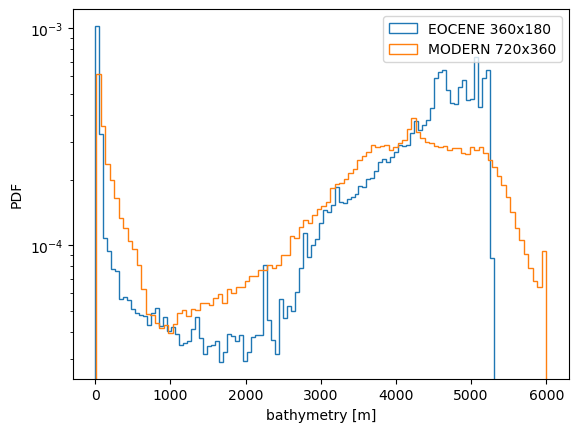

In [8]:
plt.hist(topo_eocene['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='EOCENE 360x180')
plt.hist(iwm_modern['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='MODERN 720x360')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('bathymetry [m]')

In [37]:
#iwm_modern['mask'] = iwm_modern['bathymetry'].where(iwm_modern['bathymetry'].isnull(), 1)
#iwm_modern['tidal_dissipation'] = iwm_modern['mask'] * (iwm_modern['power_bot']+iwm_modern['power_cri']+iwm_modern['power_nsq']+iwm_modern['power_sho'])

iwm_modern['mask'] = iwm_modern['bathymetry'].where(iwm_modern['bathymetry'].isnull(), 1)
comps = ['power_bot', 'power_cri', 'power_nsq', 'power_sho']
iwm_modern['tidal_dissipation'] = (
    iwm_modern['mask'] *
    iwm_modern[comps].to_array().sum("variable")
)

Text(0.5, 0, 'ratio')

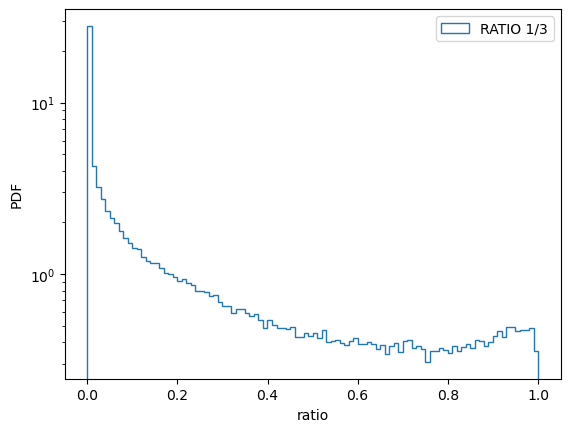

In [38]:
ratio = iwm_modern['power_cri']/iwm_modern['tidal_dissipation']
plt.hist(ratio.values.flatten(), density=True, bins=100, histtype="step", label='RATIO 1/3')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('ratio')

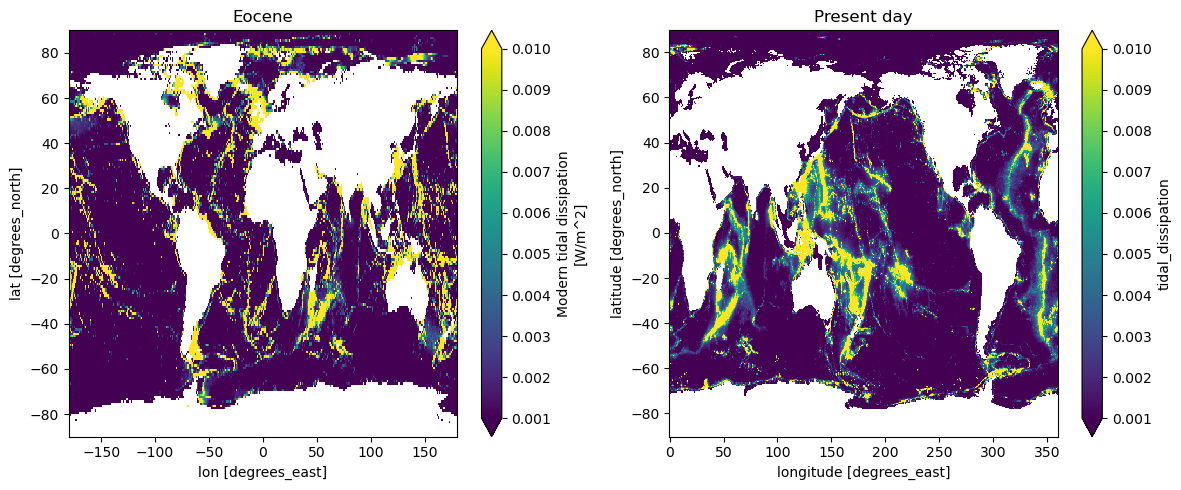

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
iwm_eocene['mod_tidal_dissipation'].plot(ax=axes[0], vmin=0.001, vmax=0.01)
axes[0].set_title("Eocene")
iwm_modern['tidal_dissipation'].plot(ax=axes[1], vmin=0.001, vmax=0.01)
axes[1].set_title("Present day")
plt.tight_layout()

In [26]:
iwm_eocene_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/eocene_tidal_dissipation_r360x180.nc")
iwm_modern_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/zdfiwm_forcing_r360x180.nc")

In [31]:
iwm_modern_remap['mask'] = iwm_modern_remap['bathymetry'].where(iwm_modern_remap['bathymetry'].isnull(), 1)
comps = ['power_bot', 'power_cri', 'power_nsq', 'power_sho']
iwm_modern_remap['tidal_dissipation'] = (
    iwm_modern_remap['mask'] *
    iwm_modern_remap[comps].to_array().sum("variable")
)

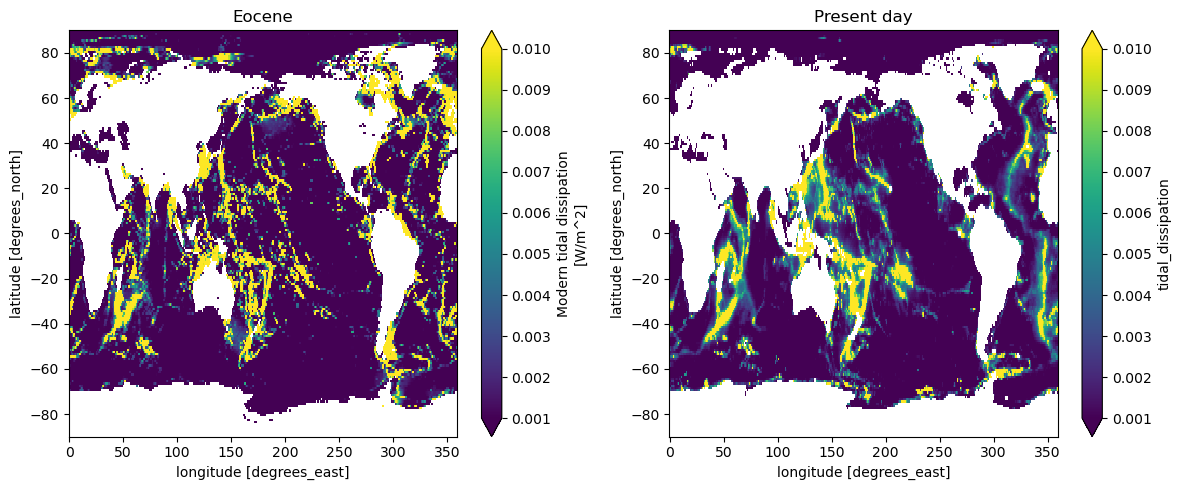

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
iwm_eocene_remap['mod_tidal_dissipation'].plot(ax=axes[0], vmin=0.001, vmax=0.01)
axes[0].set_title("Eocene")
iwm_modern_remap['tidal_dissipation'].plot(ax=axes[1], vmin=0.001, vmax=0.01)
axes[1].set_title("Present day")
plt.tight_layout()

Text(0.5, 0, 'tidal dissipation difference [W/m^2]')

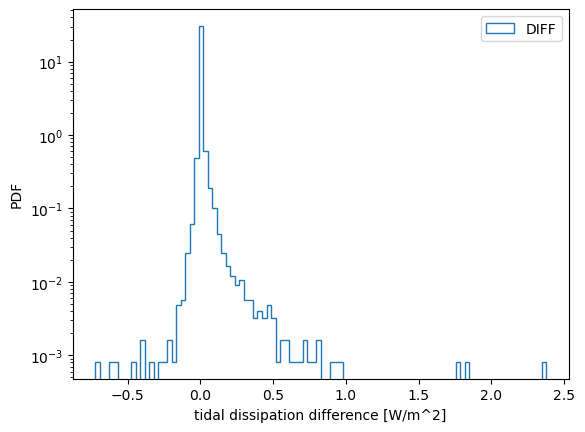

In [36]:
diff = (iwm_eocene_remap['mod_tidal_dissipation'] - iwm_modern_remap['tidal_dissipation'])
plt.hist(diff.values.flatten(), density=True, bins=100, histtype="step", label='DIFF')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation difference [W/m^2]')

Text(0.5, 0, 'tidal dissipation [W/m^2]')

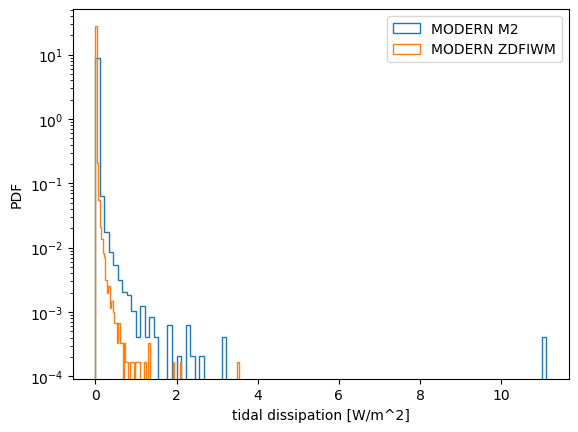

In [42]:
plt.hist(iwm_eocene_remap['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", label='MODERN M2')
plt.hist(iwm_modern['tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", label='MODERN ZDFIWM')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation [W/m^2]')

Text(0.5, 0, 'tidal dissipation [W/m^2]')

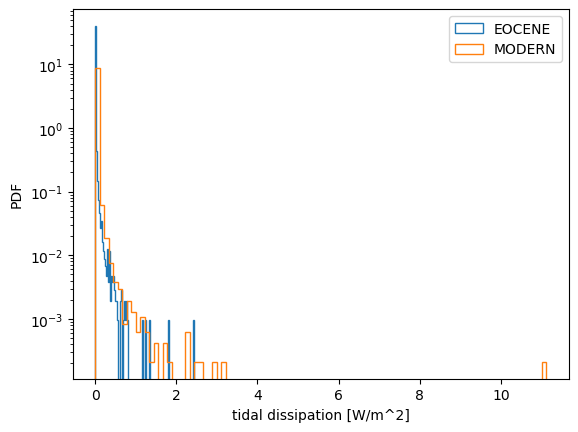

In [43]:
plt.hist(iwm_eocene['eo_tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", label='EOCENE')
plt.hist(iwm_eocene['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", label='MODERN')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation [W/m^2]')

Text(0.5, 0, 'scale critical [m]')

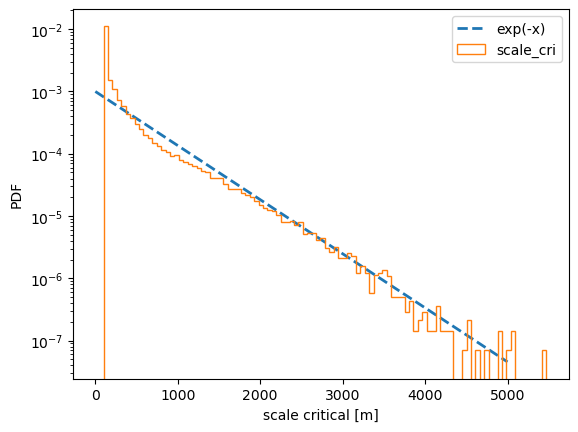

In [77]:
# Curva teorica exp(-x)
x = np.linspace(0, 5000, 100)
y = 0.001*np.exp(-x/500)
plt.plot(x, y, linewidth=2, label="exp(-x)", ls='--')
plt.hist(iwm_modern['scale_cri'].values.flatten(), density=True, bins=100, histtype="step", label='scale_cri')
#plt.hist(iwm_modern['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='bathymetry')
#plt.hist(iwm_modern['scale_bot'].values.flatten(), density=True, bins=100, histtype="step", label='scale_bot')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('scale critical [m]')

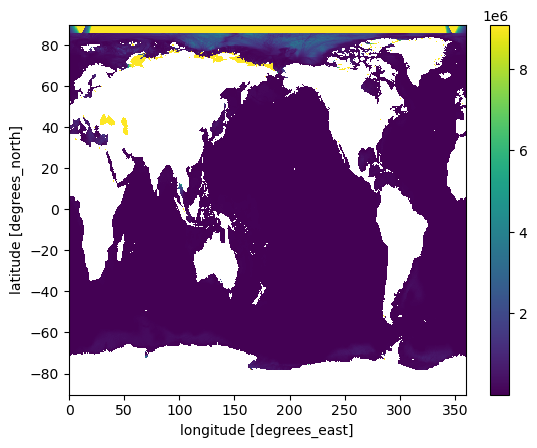

In [79]:
(iwm_modern['mask'] * iwm_modern['scale_bot']).plot()

Text(0.5, 0, 'tidal dissipation [W/m^2]')

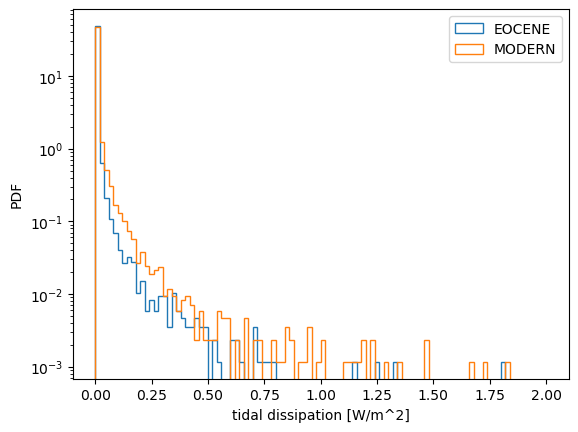

In [17]:
plt.hist(iwm_eocene['eo_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 2.0], histtype="step", label='EOCENE')
plt.hist(iwm_eocene['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 2.0], histtype="step", label='MODERN')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation [W/m^2]')

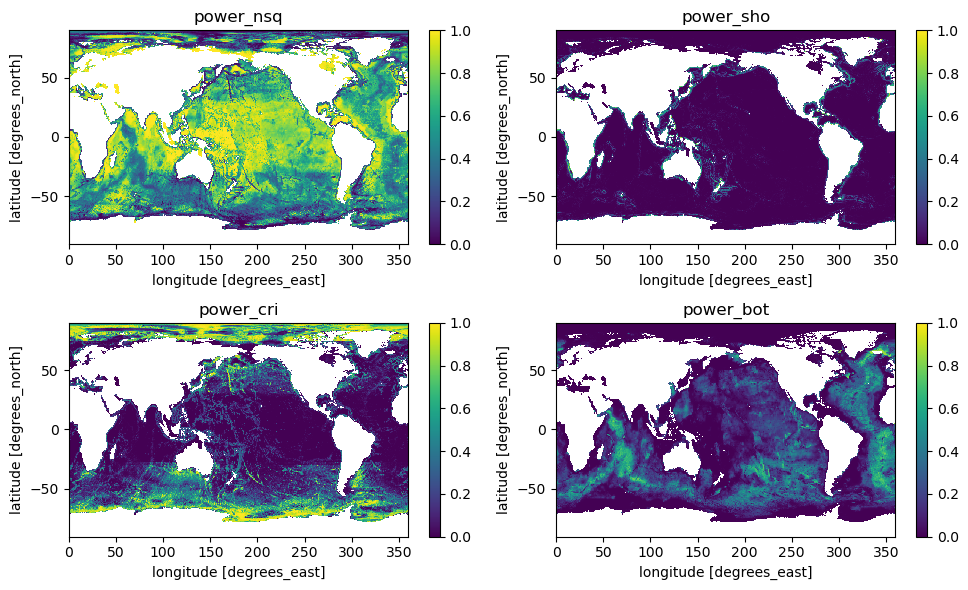

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
(iwm_modern['mask']*iwm_modern['power_nsq']/iwm_modern['tidal_dissipation']).plot(ax=axes[0][0], vmin=0.0, vmax=1.0)
axes[0][0].set_title("power_nsq")
(iwm_modern['mask']*iwm_modern['power_sho']/iwm_modern['tidal_dissipation']).plot(ax=axes[0][1], vmin=0.0, vmax=1.0)
axes[0][1].set_title("power_sho")
(iwm_modern['mask']*iwm_modern['power_cri']/iwm_modern['tidal_dissipation']).plot(ax=axes[1][0], vmin=0.0, vmax=1.0)
axes[1][0].set_title("power_cri")
(iwm_modern['mask']*iwm_modern['power_bot']/iwm_modern['tidal_dissipation']).plot(ax=axes[1][1], vmin=0.0, vmax=1.0)
axes[1][1].set_title("power_bot")
plt.tight_layout()

In [80]:
iwm_modern

<xarray.Dataset> Size: 19MB
Dimensions:            (latitude: 360, longitude: 720, lon: 360, lat: 180)
Coordinates:
  * latitude           (latitude) float64 3kB -90.0 -89.5 -89.0 ... 89.0 89.5
  * longitude          (longitude) float64 6kB 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * lon                (lon) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    power_bot          (latitude, longitude) float64 2MB 4.476e-07 ... 1.356e-09
    power_cri          (latitude, longitude) float64 2MB 6.495e-05 ... 2.631e-05
    power_nsq          (latitude, longitude) float64 2MB 4.709e-05 ... 1e-05
    power_sho          (latitude, longitude) float64 2MB 0.0001493 ... 1e-10
    scale_cri          (latitude, longitude) float64 2MB 207.8 207.8 ... 100.0
    scale_bot          (latitude, longitude) float64 2MB 1.68e+05 ... 2.295e+06
    bathymetry         (latitude, longitude) float64 2MB nan nan ... 4.221e+03
    mask               (latitude, longitude) float64 2MB nan nan nan ... 1.0 1.0
    tidal_dissipation  (latitude, longitude) float64 2MB nan nan ... 3.631e-05
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.6
    history:                   Sun Aug 04 00:59:55 2024: cdo -L -P 16 -remapn...
    CDO:                       Climate Data Operators version 1.9.8 (https://...
    cdo_openmp_thread_number:  16